# Cumulative event counter

### This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of apoptosis events

1. Load dictionary of apoptoses and their corresponding times to base the spatiotemporal scans around 
2. Load corresponding tracking data and specify scan parameters
3. Iteratively calculate spatiotemporal distribution of cellular events around apoptoses, saving each distribution out as a .npy distance-time heatmap
4. Compile list of spatiotemporal heatmaps as cumulative heatmap
5. Misc. section: comparing different experimental conditions

In [1]:
import calculate_radial_analysis as calculate
import tools
import render
import dataio

import json
import glob
import os
import re
import numpy as np
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

## 1) Apoptosis dictionary loader
Specify cell type to filter out unwanted apoptoses, want end result of apop_dict that takes the format of :`apop_dict = {apop_ID:apop_time}` 

where `apop_ID` takes the format of: `GV{experiment_ID}_Pos{position_ID}_{cell_ID}_{cell_type}` 

For example: 

```
apop_dict = {'GV0794_Pos4_393_GFP': '766',
             'GV0794_Pos7_364_GFP': '550',
             'GV0794_Pos7_457_GFP': '805',
             'GV0794_Pos7_369_GFP': '833',
             'GV0794_Pos7_292_GFP': '884',
             'GV0795_Pos4_358_GFP': '628',
             'GV0795_Pos4_18_GFP': '855',
             'GV0795_Pos4_1356_GFP': '992',
             'GV0795_Pos4_359_GFP': '1133',
             'GV0796_Pos4_542_GFP': '581',
             'GV0796_Pos4_1334_GFP': '719',
             'GV0796_Pos4_1586_GFP': '785'}
 ```
 
Function to load apoptosis dictionary from preexisting data store:

`dataio.apoptosis_list_loader(path_to_apop_lists, cell_type)`

Where the `path_to_apop_lists` is the directory containing the apoptosis information and the `cell_type` is either `'Scr'` or `'WT'`.

In [2]:
path_to_apop_lists = '/home/nathan/data/kraken/h2b/giulia/apoptosis_information/final/all'
apop_dict = dataio.apoptosis_list_loader(path_to_apop_lists, 'Scr')
apop_dict

{'GV0797_Pos21_78_RFP': '186',
 'GV0797_Pos21_54_RFP': '238',
 'GV0797_Pos21_55_RFP': '268',
 'GV0797_Pos21_83_RFP': '372',
 'GV0797_Pos21_302_RFP': '380',
 'GV0797_Pos21_22_RFP': '476',
 'GV0797_Pos21_335_RFP': '506',
 'GV0797_Pos21_334_RFP': '607',
 'GV0797_Pos21_35_RFP': '634',
 'GV0816_Pos0_406_RFP': '774',
 'GV0816_Pos0_351_RFP': '873',
 'GV0816_Pos0_374_RFP': '911',
 'GV0816_Pos0_526_RFP': '904',
 'GV0816_Pos0_343_RFP': '943',
 'GV0800_Pos8_9_RFP': '109',
 'GV0800_Pos8_74_RFP': '438',
 'GV0800_Pos8_75_RFP': '546',
 'GV0800_Pos8_118_RFP': '699',
 'GV0800_Pos8_160_RFP': '806',
 'GV0800_Pos8_162_RFP': '806',
 'GV0796_Pos21_13_RFP': '71',
 'GV0796_Pos21_16_RFP': '131',
 'GV0796_Pos21_30_RFP': '136',
 'GV0796_Pos21_23_RFP': '244',
 'GV0796_Pos21_14_RFP': '272',
 'GV0796_Pos21_230_RFP': '343',
 'GV0796_Pos21_314_RFP': '451',
 'GV0796_Pos21_252_RFP': '547',
 'GV0796_Pos21_282_RFP': '642',
 'GV0796_Pos21_18_RFP': '679',
 'GV0796_Pos21_676_RFP': '719',
 'GV0796_Pos21_675_RFP': '720',
 'GV

In [3]:
### optional parallelisation step
N_apops = len(apop_dict)
para_frac_min, para_frac_max = int(0*N_apops), int(0.25*N_apops)  ## ie only do first 1/4 of all apops
delete_list =[]
for i, j in enumerate(apop_dict):
    if not para_frac_min <= i< para_frac_max: 
        delete_list.append(j)
for i in delete_list:
    del apop_dict[i]
print("Length of modified dict vs original:", len(apop_dict), "/", N_apops)

Length of modified dict vs original: 459 / 1839


## 2) Load corresponding cell tracking data and specifiy other parameters

`dataio.hdf5_file_finder(parent_folder_hdf5)` loads a list of all hdf5 files when supplied with the parent directory of all the experiments. This relies on a typical sub-parent directory structure of `'GV****/Pos*/*aligned/HDF/segmented.hdf5'` (aligned folder optional)

In [4]:
### load tracking data
parent_folder_hdf5 = '/home/nathan/data/kraken/h2b/giulia'
hdf5_file_list = dataio.hdf5_file_finder(parent_folder_hdf5)

### specify output path and neighbourhood scan parameters
radius, t_range, num_bins = 400, 400, 10#800, 800, 20#400, 400, 10
output_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/{}.{}.{}/scr_apop_wt_div'.format(radius, t_range, num_bins)
Path(output_path).mkdir(parents=True, exist_ok=True)

## 3) Iteratively calculate and save out individual heatmaps

This step can be time consuming (sequential scans around 385 apoptoses took 7 hours on i7)

Function to calculate:

`calculate.iterative_heatmap_generator(subject_cells = 'WT', subject_event = 'DIVIDE', apop_dict, hdf5_file_list, radius, t_range, num_bins, output_path)`

Where the necessary input variables are as follows:
- `subject_cells` = The population of cells to scan over looking for events, 'WT'/'Scr'/'All'
- `subject_event` = The event type to look for, 'DIVIDE' or 'APOPTOSIS'
- `apop_dict` = Previously defined python dictionary of {apoptosis ID: apoptosis time}
- `hdf5_file_list` = List of locations of tracking files
- `radius` = Distance to scan over around apoptosis
- `t_range` = Time range to scan over around apoptosis (will scan t_range/2 before and after apoptosis)
- `num_bins` = Number of bins the histogram is sorted into
- `output_path` = Empty directory to save out individual apoptosis heatmap .npy arrays into


In [5]:
N_cells, error_log, success_log = calculate.iterative_heatmap_generator(
    'WT', ## 'Scr',
    'DIVIDE', 
    apop_dict, 
    hdf5_file_list, 
    radius, 
    t_range, 
    num_bins, 
    output_path)

  0%|          | 0/459 [00:00<?, ?it/s][INFO][2021/05/04 05:22:50 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:22:50 PM] Loading tracks/obj_type_1


ID GV0797_Pos21_78_RFP
Loading GV0797/Pos21/
Btrack version no.: 0.4.0


[INFO][2021/05/04 05:22:52 PM] Loading objects/obj_type_1 (211568, 5) (195992 filtered: area>=100)
[INFO][2021/05/04 05:22:53 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 05:22:53 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:22:53 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 05:22:54 PM] Loading objects/obj_type_2 (26227, 5) (20975 filtered: area>=100)
[INFO][2021/05/04 05:22:54 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos21/


  0%|          | 1/459 [00:41<5:16:46, 41.50s/it]

ID GV0797_Pos21_54_RFP


  0%|          | 2/459 [01:32<5:37:45, 44.35s/it]

ID GV0797_Pos21_55_RFP


  1%|          | 3/459 [02:28<6:04:16, 47.93s/it]

ID GV0797_Pos21_83_RFP


  1%|          | 4/459 [03:38<6:54:02, 54.60s/it]

ID GV0797_Pos21_302_RFP


  1%|          | 5/459 [04:22<6:28:18, 51.32s/it]

ID GV0797_Pos21_22_RFP


  1%|▏         | 6/459 [05:58<8:08:52, 64.75s/it]

ID GV0797_Pos21_335_RFP


  2%|▏         | 7/459 [06:52<7:42:28, 61.39s/it]

ID GV0797_Pos21_334_RFP


  2%|▏         | 8/459 [07:52<7:39:24, 61.12s/it]

ID GV0797_Pos21_35_RFP


  2%|▏         | 9/459 [09:40<9:24:21, 75.25s/it][INFO][2021/05/04 05:32:31 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:32:31 PM] Loading tracks/obj_type_1


ID GV0816_Pos0_406_RFP
Loading GV0816/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/04 05:32:32 PM] Loading objects/obj_type_1 (90368, 5) (81699 filtered: area>=100)
[INFO][2021/05/04 05:32:33 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 05:32:33 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:32:33 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 05:32:33 PM] Loading objects/obj_type_2 (24057, 5) (17173 filtered: area>=100)
[INFO][2021/05/04 05:32:33 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos0/


  2%|▏         | 10/459 [10:02<7:22:04, 59.07s/it]

ID GV0816_Pos0_351_RFP


  2%|▏         | 11/459 [10:48<6:51:29, 55.11s/it]

ID GV0816_Pos0_374_RFP


  3%|▎         | 12/459 [11:30<6:21:35, 51.22s/it]

ID GV0816_Pos0_526_RFP


  3%|▎         | 13/459 [11:49<5:08:56, 41.56s/it]

ID GV0816_Pos0_343_RFP


  3%|▎         | 14/459 [12:31<5:09:22, 41.71s/it][INFO][2021/05/04 05:35:22 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:35:22 PM] Loading tracks/obj_type_1


ID GV0800_Pos8_9_RFP
Loading GV0800/Pos8/
Btrack version no.: 0.4.0


[INFO][2021/05/04 05:35:24 PM] Loading objects/obj_type_1 (412266, 5) (393638 filtered: area>=100)
[INFO][2021/05/04 05:35:28 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 05:35:28 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:35:28 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 05:35:28 PM] Loading objects/obj_type_2 (16111, 5) (12664 filtered: area>=100)
[INFO][2021/05/04 05:35:28 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos8/


  3%|▎         | 15/459 [14:32<8:04:48, 65.51s/it]

ID GV0800_Pos8_74_RFP


  3%|▎         | 16/459 [15:40<8:10:06, 66.38s/it]

ID GV0800_Pos8_75_RFP


  4%|▎         | 17/459 [17:21<9:25:33, 76.77s/it]

ID GV0800_Pos8_118_RFP


  4%|▍         | 18/459 [19:02<10:17:53, 84.07s/it]

ID GV0800_Pos8_160_RFP


  4%|▍         | 19/459 [20:29<10:21:44, 84.78s/it]

ID GV0800_Pos8_162_RFP


  4%|▍         | 20/459 [21:52<10:16:03, 84.20s/it][INFO][2021/05/04 05:44:43 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:44:43 PM] Loading tracks/obj_type_1


ID GV0796_Pos21_13_RFP
Loading GV0796/Pos21/
Btrack version no.: 0.4.0


[INFO][2021/05/04 05:44:44 PM] Loading objects/obj_type_1 (307793, 5) (293005 filtered: area>=100)
[INFO][2021/05/04 05:44:47 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 05:44:47 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 05:44:47 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 05:44:48 PM] Loading objects/obj_type_2 (46439, 5) (38835 filtered: area>=100)
[INFO][2021/05/04 05:44:48 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos21/


  5%|▍         | 21/459 [23:14<10:09:29, 83.49s/it]

ID GV0796_Pos21_16_RFP


  5%|▍         | 22/459 [24:17<9:24:47, 77.55s/it] 

ID GV0796_Pos21_30_RFP


  5%|▌         | 23/459 [25:14<8:38:46, 71.39s/it]

ID GV0796_Pos21_23_RFP


  5%|▌         | 24/459 [26:49<9:28:36, 78.43s/it]

ID GV0796_Pos21_14_RFP


  5%|▌         | 25/459 [28:13<9:40:10, 80.21s/it]

ID GV0796_Pos21_230_RFP


  6%|▌         | 26/459 [29:15<8:58:44, 74.65s/it]

ID GV0796_Pos21_314_RFP


  6%|▌         | 27/459 [29:50<7:31:55, 62.77s/it]

ID GV0796_Pos21_252_RFP


  6%|▌         | 28/459 [31:28<8:46:39, 73.32s/it]

ID GV0796_Pos21_282_RFP


  6%|▋         | 29/459 [33:17<10:01:14, 83.89s/it]

ID GV0796_Pos21_18_RFP


  7%|▋         | 30/459 [36:17<13:26:01, 112.73s/it]

ID GV0796_Pos21_676_RFP


  7%|▋         | 31/459 [37:23<11:44:53, 98.82s/it] 

ID GV0796_Pos21_675_RFP


  7%|▋         | 32/459 [38:26<10:27:38, 88.19s/it]

ID GV0796_Pos21_336_RFP


  7%|▋         | 33/459 [40:10<10:58:26, 92.74s/it]

ID GV0796_Pos21_339_RFP


  7%|▋         | 34/459 [41:52<11:17:31, 95.65s/it]

ID GV0796_Pos21_406_RFP


  8%|▊         | 35/459 [43:21<11:02:02, 93.69s/it]

ID GV0796_Pos21_697_RFP


  8%|▊         | 36/459 [43:56<8:55:09, 75.91s/it] 

ID GV0796_Pos21_425_RFP


  8%|▊         | 37/459 [45:23<9:16:59, 79.19s/it]

ID GV0796_Pos21_702_RFP


  8%|▊         | 38/459 [46:10<8:07:40, 69.50s/it]

ID GV0796_Pos21_257_RFP


  8%|▊         | 39/459 [48:50<11:16:48, 96.69s/it]

ID GV0796_Pos21_312_RFP


  9%|▊         | 40/459 [50:59<12:22:42, 106.35s/it]

ID GV0796_Pos21_388_RFP


  9%|▉         | 41/459 [52:56<12:44:59, 109.81s/it]

ID GV0796_Pos21_646_RFP


  9%|▉         | 42/459 [54:42<12:34:31, 108.56s/it]

ID GV0796_Pos21_665_RFP


  9%|▉         | 43/459 [56:24<12:18:40, 106.54s/it]

ID GV0796_Pos21_405_RFP


 10%|▉         | 44/459 [58:11<12:17:03, 106.56s/it][INFO][2021/05/04 06:21:01 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:21:01 PM] Loading tracks/obj_type_1


ID GV0795_Pos8_5_RFP
Loading GV0795/Pos8/
Btrack version no.: 0.4.0


[INFO][2021/05/04 06:21:03 PM] Loading objects/obj_type_1 (273725, 5) (262060 filtered: area>=100)
[INFO][2021/05/04 06:21:05 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 06:21:05 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:21:05 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 06:21:05 PM] Loading objects/obj_type_2 (12522, 5) (9142 filtered: area>=100)
[INFO][2021/05/04 06:21:06 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos8/


 10%|▉         | 45/459 [59:20<10:57:38, 95.31s/it] 

ID GV0795_Pos8_3_RFP


 10%|█         | 46/459 [1:00:08<9:19:24, 81.27s/it]

ID GV0795_Pos8_1_RFP


 10%|█         | 47/459 [1:00:29<7:13:59, 63.20s/it]

ID GV0795_Pos8_144_RFP


 10%|█         | 48/459 [1:02:39<9:30:50, 83.33s/it]

ID GV0795_Pos8_234_RFP


 11%|█         | 49/459 [1:03:24<8:10:32, 71.79s/it]

ID GV0795_Pos8_233_RFP


 11%|█         | 50/459 [1:04:42<8:21:19, 73.54s/it]

ID GV0795_Pos8_7_RFP


 11%|█         | 51/459 [1:08:13<12:59:40, 114.66s/it][INFO][2021/05/04 06:31:03 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:31:03 PM] Loading tracks/obj_type_1


ID GV0795_Pos6_41_RFP
Loading GV0795/Pos6/
Btrack version no.: 0.4.0


[INFO][2021/05/04 06:31:04 PM] Loading objects/obj_type_1 (52858, 5) (43022 filtered: area>=100)
[INFO][2021/05/04 06:31:04 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 06:31:04 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:31:04 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 06:31:05 PM] Loading objects/obj_type_2 (95556, 5) (72517 filtered: area>=100)
[INFO][2021/05/04 06:31:05 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos6/


 11%|█▏        | 52/459 [1:08:27<9:33:23, 84.53s/it]  

ID GV0795_Pos6_762_RFP


 12%|█▏        | 53/459 [1:08:55<7:37:51, 67.66s/it]

ID GV0795_Pos6_380_RFP


 12%|█▏        | 54/459 [1:09:21<6:11:56, 55.10s/it]

ID GV0795_Pos6_185_RFP


 12%|█▏        | 55/459 [1:09:36<4:50:54, 43.20s/it]

ID GV0795_Pos6_252_RFP


 12%|█▏        | 56/459 [1:09:49<3:48:34, 34.03s/it]

ID GV0795_Pos6_184_RFP


 12%|█▏        | 57/459 [1:10:00<3:02:44, 27.28s/it]

ID GV0795_Pos6_259_RFP


 13%|█▎        | 58/459 [1:10:20<2:46:40, 24.94s/it]

ID GV0795_Pos6_736_RFP


 13%|█▎        | 59/459 [1:10:22<2:01:25, 18.21s/it]

ID GV0795_Pos6_734_RFP


 13%|█▎        | 60/459 [1:10:25<1:30:00, 13.54s/it]

ID GV0795_Pos6_417_RFP


 13%|█▎        | 61/459 [1:11:01<2:13:57, 20.19s/it]

ID GV0795_Pos6_1093_RFP


 14%|█▎        | 62/459 [1:11:21<2:12:39, 20.05s/it]

ID GV0795_Pos6_372_RFP


 14%|█▎        | 63/459 [1:11:52<2:35:15, 23.52s/it]

ID GV0795_Pos6_34_RFP


 14%|█▍        | 64/459 [1:12:50<3:42:47, 33.84s/it]

ID GV0795_Pos6_1094_RFP


 14%|█▍        | 65/459 [1:13:10<3:14:53, 29.68s/it]

ID GV0795_Pos6_1041_RFP


 14%|█▍        | 66/459 [1:13:31<2:57:36, 27.11s/it]

ID GV0795_Pos6_1353_RFP


 15%|█▍        | 67/459 [1:13:34<2:09:08, 19.77s/it]

ID GV0795_Pos6_425_RFP


 15%|█▍        | 68/459 [1:14:19<2:57:42, 27.27s/it]

ID GV0795_Pos6_426_RFP


 15%|█▌        | 69/459 [1:15:03<3:30:13, 32.34s/it]

ID GV0795_Pos6_48_RFP


 15%|█▌        | 70/459 [1:16:13<4:43:58, 43.80s/it]

ID GV0795_Pos6_19_RFP


 15%|█▌        | 71/459 [1:16:54<4:37:06, 42.85s/it]

ID GV0795_Pos6_653_RFP


 16%|█▌        | 72/459 [1:17:11<3:47:15, 35.23s/it]

ID GV0795_Pos6_413_RFP


 16%|█▌        | 73/459 [1:17:27<3:09:06, 29.40s/it]

ID GV0795_Pos6_96_RFP


 16%|█▌        | 74/459 [1:18:05<3:25:31, 32.03s/it]

ID GV0795_Pos6_414_RFP


 16%|█▋        | 75/459 [1:18:20<2:51:14, 26.76s/it]

ID GV0795_Pos6_97_RFP


 17%|█▋        | 76/459 [1:18:58<3:13:14, 30.27s/it]

ID GV0795_Pos6_654_RFP


 17%|█▋        | 77/459 [1:19:13<2:43:08, 25.62s/it]

ID GV0795_Pos6_578_RFP


 17%|█▋        | 78/459 [1:19:42<2:49:45, 26.73s/it]

ID GV0795_Pos6_1026_RFP


 17%|█▋        | 79/459 [1:20:05<2:42:11, 25.61s/it]

ID GV0795_Pos6_11_RFP


 17%|█▋        | 80/459 [1:21:18<4:11:30, 39.82s/it]

ID GV0795_Pos6_619_RFP


 18%|█▊        | 81/459 [1:21:39<3:34:49, 34.10s/it]

ID GV0795_Pos6_700_RFP


 18%|█▊        | 82/459 [1:22:08<3:23:48, 32.44s/it]

ID GV0795_Pos6_579_RFP


 18%|█▊        | 83/459 [1:22:45<3:31:58, 33.83s/it]

ID GV0795_Pos6_967_RFP


 18%|█▊        | 84/459 [1:23:03<3:02:07, 29.14s/it]

ID GV0795_Pos6_160_RFP


 19%|█▊        | 85/459 [1:23:47<3:28:42, 33.48s/it][INFO][2021/05/04 06:46:37 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:46:37 PM] Loading tracks/obj_type_1


ID GV0796_Pos6_570_RFP
Loading GV0796/Pos6/
Btrack version no.: 0.4.0


[INFO][2021/05/04 06:46:38 PM] Loading objects/obj_type_1 (70354, 5) (57413 filtered: area>=100)
[INFO][2021/05/04 06:46:38 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 06:46:38 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:46:38 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 06:46:39 PM] Loading objects/obj_type_2 (88276, 5) (68435 filtered: area>=100)
[INFO][2021/05/04 06:46:39 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos6/


 19%|█▊        | 86/459 [1:24:00<2:50:00, 27.35s/it]

ID GV0796_Pos6_569_RFP


 19%|█▉        | 87/459 [1:24:10<2:18:41, 22.37s/it]

ID GV0796_Pos6_60_RFP


 19%|█▉        | 88/459 [1:24:57<3:04:14, 29.80s/it]

ID GV0796_Pos6_57_RFP


 19%|█▉        | 89/459 [1:25:58<3:59:59, 38.92s/it]

ID GV0796_Pos6_344_RFP


 20%|█▉        | 90/459 [1:26:28<3:42:44, 36.22s/it]

ID GV0796_Pos6_39_RFP


 20%|█▉        | 91/459 [1:27:25<4:20:35, 42.49s/it]

ID GV0796_Pos6_664_RFP


 20%|██        | 92/459 [1:28:00<4:07:20, 40.44s/it]

ID GV0796_Pos6_565_RFP


 20%|██        | 93/459 [1:28:47<4:18:03, 42.30s/it]

ID GV0796_Pos6_566_RFP


 20%|██        | 94/459 [1:29:23<4:05:35, 40.37s/it]

ID GV0796_Pos6_841_RFP


 21%|██        | 95/459 [1:29:35<3:14:24, 32.05s/it]

ID GV0796_Pos6_541_RFP


 21%|██        | 96/459 [1:30:04<3:06:46, 30.87s/it]

ID GV0796_Pos6_839_RFP


 21%|██        | 97/459 [1:30:17<2:34:20, 25.58s/it]

ID GV0796_Pos6_579_RFP


 21%|██▏       | 98/459 [1:30:46<2:40:21, 26.65s/it]

ID GV0796_Pos6_542_RFP


 22%|██▏       | 99/459 [1:31:18<2:50:10, 28.36s/it]

ID GV0796_Pos6_201_RFP


 22%|██▏       | 100/459 [1:31:59<3:12:29, 32.17s/it]

ID GV0796_Pos6_881_RFP


 22%|██▏       | 101/459 [1:32:25<2:59:39, 30.11s/it]

ID GV0796_Pos6_7_RFP


 22%|██▏       | 102/459 [1:33:32<4:05:42, 41.30s/it]

ID GV0796_Pos6_638_RFP


 22%|██▏       | 103/459 [1:34:07<3:53:25, 39.34s/it]

ID GV0796_Pos6_1063_RFP


 23%|██▎       | 104/459 [1:34:23<3:10:50, 32.25s/it]

ID GV0796_Pos6_30_RFP


 23%|██▎       | 105/459 [1:34:33<2:31:36, 25.70s/it]

ID GV0796_Pos6_86_RFP


 23%|██▎       | 106/459 [1:34:54<2:22:29, 24.22s/it]

ID GV0796_Pos6_1022_RFP


 23%|██▎       | 107/459 [1:35:01<1:51:25, 18.99s/it]

ID GV0796_Pos6_1146_RFP


 24%|██▎       | 108/459 [1:35:08<1:31:31, 15.65s/it]

ID GV0796_Pos6_885_RFP


 24%|██▎       | 109/459 [1:35:37<1:53:48, 19.51s/it]

ID GV0796_Pos6_1021_RFP


 24%|██▍       | 110/459 [1:36:00<1:59:42, 20.58s/it]

ID GV0796_Pos6_18_RFP


 24%|██▍       | 111/459 [1:36:26<2:07:57, 22.06s/it][INFO][2021/05/04 06:59:16 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:59:16 PM] Loading tracks/obj_type_1


ID GV0807_Pos5_4_RFP
Loading GV0807/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/04 06:59:17 PM] Loading objects/obj_type_1 (129954, 5) (111411 filtered: area>=100)
[INFO][2021/05/04 06:59:18 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 06:59:18 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 06:59:18 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 06:59:18 PM] Loading objects/obj_type_2 (87213, 5) (74295 filtered: area>=100)
[INFO][2021/05/04 06:59:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0807/Pos5/


 24%|██▍       | 112/459 [1:36:38<1:50:15, 19.07s/it]

ID GV0807_Pos5_52_RFP


 25%|██▍       | 113/459 [1:36:49<1:36:45, 16.78s/it]

ID GV0807_Pos5_301_RFP


 25%|██▍       | 114/459 [1:36:58<1:22:16, 14.31s/it]

ID GV0807_Pos5_459_RFP


 25%|██▌       | 115/459 [1:37:19<1:34:39, 16.51s/it]

ID GV0807_Pos5_402_RFP


 25%|██▌       | 116/459 [1:37:59<2:14:50, 23.59s/it]

ID GV0807_Pos5_354_RFP


 25%|██▌       | 117/459 [1:38:47<2:56:21, 30.94s/it]

ID GV0807_Pos5_679_RFP


 26%|██▌       | 118/459 [1:39:07<2:36:29, 27.54s/it]

ID GV0807_Pos5_950_RFP


 26%|██▌       | 119/459 [1:39:23<2:16:53, 24.16s/it]

ID GV0807_Pos5_952_RFP


 26%|██▌       | 120/459 [1:39:41<2:05:06, 22.14s/it]

ID GV0807_Pos5_334_RFP


 26%|██▋       | 121/459 [1:40:59<3:39:59, 39.05s/it]

ID GV0807_Pos5_733_RFP


 27%|██▋       | 122/459 [1:42:06<4:26:34, 47.46s/it]

ID GV0807_Pos5_916_RFP


 27%|██▋       | 123/459 [1:42:26<3:38:30, 39.02s/it]

ID GV0807_Pos5_677_RFP


 27%|██▋       | 124/459 [1:43:18<3:59:23, 42.88s/it]

ID GV0807_Pos5_1128_RFP


 27%|██▋       | 125/459 [1:43:33<3:13:10, 34.70s/it]

ID GV0807_Pos5_460_RFP


 27%|██▋       | 126/459 [1:44:15<3:24:51, 36.91s/it]

ID GV0807_Pos5_51_RFP


 28%|██▊       | 127/459 [1:46:06<5:26:46, 59.05s/it]

ID GV0807_Pos5_977_RFP


 28%|██▊       | 128/459 [1:46:34<4:34:00, 49.67s/it]

ID GV0807_Pos5_1149_RFP


 28%|██▊       | 129/459 [1:47:15<4:18:36, 47.02s/it]

ID GV0807_Pos5_815_RFP


 28%|██▊       | 130/459 [1:48:09<4:30:28, 49.33s/it]

ID GV0807_Pos5_2_RFP


 29%|██▊       | 131/459 [1:50:24<6:49:19, 74.88s/it]

ID GV0807_Pos5_1281_RFP


 29%|██▉       | 132/459 [1:51:00<5:45:18, 63.36s/it]

ID GV0807_Pos5_1448_RFP


 29%|██▉       | 133/459 [1:51:14<4:23:40, 48.53s/it]

ID GV0807_Pos5_1427_RFP


 29%|██▉       | 134/459 [1:51:32<3:32:15, 39.19s/it]

ID GV0807_Pos5_1489_RFP


 29%|██▉       | 135/459 [1:51:39<2:39:41, 29.57s/it]

ID GV0807_Pos5_944_RFP


 30%|██▉       | 136/459 [1:52:35<3:22:20, 37.59s/it]

ID GV0807_Pos5_819_RFP


 30%|██▉       | 137/459 [1:53:20<3:34:19, 39.94s/it]

ID GV0807_Pos5_793_RFP


 30%|███       | 138/459 [1:54:29<4:19:43, 48.55s/it][INFO][2021/05/04 07:17:20 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:17:20 PM] Loading tracks/obj_type_1


ID GV0796_Pos23_66_RFP
Loading GV0796/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/04 07:17:20 PM] Loading objects/obj_type_1 (95277, 5) (83305 filtered: area>=100)
[INFO][2021/05/04 07:17:21 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 07:17:21 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:17:21 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 07:17:22 PM] Loading objects/obj_type_2 (126378, 5) (98072 filtered: area>=100)
[INFO][2021/05/04 07:17:23 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos23/


 30%|███       | 139/459 [1:54:39<3:16:52, 36.91s/it]

ID GV0796_Pos23_87_RFP


 31%|███       | 140/459 [1:54:48<2:32:48, 28.74s/it]

ID GV0796_Pos23_62_RFP


 31%|███       | 141/459 [1:55:29<2:50:27, 32.16s/it]

ID GV0796_Pos23_74_RFP


 31%|███       | 142/459 [1:56:07<3:00:20, 34.13s/it]

ID GV0796_Pos23_18_RFP


 31%|███       | 143/459 [1:56:37<2:53:12, 32.89s/it]

ID GV0796_Pos23_202_RFP


 31%|███▏      | 144/459 [1:57:38<3:36:14, 41.19s/it]

ID GV0796_Pos23_786_RFP


 32%|███▏      | 145/459 [1:58:11<3:22:33, 38.71s/it]

ID GV0796_Pos23_15_RFP


 32%|███▏      | 146/459 [1:59:38<4:37:04, 53.11s/it]

ID GV0796_Pos23_1896_RFP


 32%|███▏      | 147/459 [1:59:59<3:46:35, 43.58s/it]

ID GV0796_Pos23_2215_RFP


 32%|███▏      | 148/459 [2:00:08<2:51:57, 33.18s/it]

ID GV0796_Pos23_890_RFP


 32%|███▏      | 149/459 [2:00:40<2:50:01, 32.91s/it]

ID GV0796_Pos23_771_RFP


 33%|███▎      | 150/459 [2:01:20<3:00:11, 34.99s/it]

ID GV0796_Pos23_968_RFP


 33%|███▎      | 151/459 [2:02:01<3:09:06, 36.84s/it]

ID GV0796_Pos23_969_RFP


 33%|███▎      | 152/459 [2:02:34<3:02:24, 35.65s/it]

ID GV0796_Pos23_1773_RFP


 33%|███▎      | 153/459 [2:02:50<2:32:32, 29.91s/it]

ID GV0796_Pos23_1253_RFP


 34%|███▎      | 154/459 [2:03:02<2:04:47, 24.55s/it]

ID GV0796_Pos23_16_RFP


 34%|███▍      | 155/459 [2:03:07<1:34:37, 18.68s/it]

ID GV0796_Pos23_80_RFP


 34%|███▍      | 156/459 [2:03:56<2:19:16, 27.58s/it]

ID GV0796_Pos23_525_RFP


 34%|███▍      | 157/459 [2:04:55<3:07:08, 37.18s/it]

ID GV0796_Pos23_1767_RFP


 34%|███▍      | 158/459 [2:05:20<2:47:18, 33.35s/it]

ID GV0796_Pos23_203_RFP


 35%|███▍      | 159/459 [2:05:35<2:18:47, 27.76s/it]

ID GV0796_Pos23_36_RFP


 35%|███▍      | 160/459 [2:05:57<2:09:49, 26.05s/it]

ID GV0796_Pos23_174_RFP


 35%|███▌      | 161/459 [2:06:36<2:29:39, 30.13s/it]

ID GV0796_Pos23_655_RFP


 35%|███▌      | 162/459 [2:07:02<2:22:12, 28.73s/it]

ID GV0796_Pos23_717_RFP


 36%|███▌      | 163/459 [2:07:30<2:21:21, 28.65s/it]

ID GV0796_Pos23_718_RFP


 36%|███▌      | 164/459 [2:07:59<2:21:37, 28.80s/it]

ID GV0796_Pos23_526_RFP


 36%|███▌      | 165/459 [2:08:49<2:51:42, 35.04s/it]

ID GV0796_Pos23_323_RFP


 36%|███▌      | 166/459 [2:09:41<3:16:01, 40.14s/it]

ID GV0796_Pos23_798_RFP


 36%|███▋      | 167/459 [2:10:23<3:17:38, 40.61s/it]

ID GV0796_Pos23_1306_RFP


 37%|███▋      | 168/459 [2:10:38<2:39:49, 32.96s/it]

ID GV0796_Pos23_1073_RFP


 37%|███▋      | 169/459 [2:10:55<2:17:02, 28.35s/it]

ID GV0796_Pos23_799_RFP


 37%|███▋      | 170/459 [2:11:26<2:19:35, 28.98s/it]

ID GV0796_Pos23_1412_RFP


 37%|███▋      | 171/459 [2:11:31<1:45:00, 21.88s/it]

ID GV0796_Pos23_1898_RFP


 37%|███▋      | 172/459 [2:11:41<1:27:51, 18.37s/it]

ID GV0796_Pos23_485_RFP


 38%|███▊      | 173/459 [2:12:28<2:07:59, 26.85s/it]

ID GV0796_Pos23_1466_RFP


 38%|███▊      | 174/459 [2:12:34<1:38:03, 20.64s/it]

ID GV0796_Pos23_770_RFP


 38%|███▊      | 175/459 [2:13:25<2:20:36, 29.71s/it][INFO][2021/05/04 07:36:16 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:36:16 PM] Loading tracks/obj_type_1
[INFO][2021/05/04 07:36:16 PM] Loading objects/obj_type_1 (23980, 5) (18959 filtered: area>=100)


ID GV0797_Pos23_31_RFP
Loading GV0797/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/04 07:36:16 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 07:36:16 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:36:16 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 07:36:16 PM] Loading objects/obj_type_2 (34897, 5) (24894 filtered: area>=100)
[INFO][2021/05/04 07:36:16 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos23/


 38%|███▊      | 176/459 [2:13:35<1:51:49, 23.71s/it]

ID GV0797_Pos23_26_RFP


 39%|███▊      | 177/459 [2:13:37<1:20:52, 17.21s/it]

ID GV0797_Pos23_260_RFP


 39%|███▉      | 178/459 [2:13:39<59:38, 12.74s/it]  

ID GV0797_Pos23_125_RFP


 39%|███▉      | 179/459 [2:13:41<44:43,  9.58s/it]

ID GV0797_Pos23_336_RFP


 39%|███▉      | 180/459 [2:13:48<41:05,  8.84s/it]

ID GV0797_Pos23_252_RFP


 39%|███▉      | 181/459 [2:13:50<31:09,  6.73s/it]

ID GV0797_Pos23_301_RFP


 40%|███▉      | 182/459 [2:13:51<23:07,  5.01s/it]

ID GV0797_Pos23_36_RFP


 40%|███▉      | 183/459 [2:13:56<23:25,  5.09s/it]

ID GV0797_Pos23_319_RFP


 40%|████      | 184/459 [2:14:06<29:07,  6.35s/it]

ID GV0797_Pos23_556_RFP


 40%|████      | 185/459 [2:14:11<27:40,  6.06s/it][INFO][2021/05/04 07:37:02 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:37:02 PM] Loading tracks/obj_type_1


ID GV0813_Pos5_212_RFP
Loading GV0813/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/04 07:37:03 PM] Loading objects/obj_type_1 (160205, 5) (133425 filtered: area>=100)
[INFO][2021/05/04 07:37:04 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 07:37:04 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:37:04 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 07:37:04 PM] Loading objects/obj_type_2 (23703, 5) (19617 filtered: area>=100)
[INFO][2021/05/04 07:37:04 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos5/


 41%|████      | 186/459 [2:14:32<47:44, 10.49s/it]

ID GV0813_Pos5_340_RFP


 41%|████      | 187/459 [2:14:51<59:54, 13.22s/it]

ID GV0813_Pos5_210_RFP


 41%|████      | 188/459 [2:16:10<2:28:41, 32.92s/it]

ID GV0813_Pos5_155_RFP


 41%|████      | 189/459 [2:17:31<3:31:56, 47.10s/it][INFO][2021/05/04 07:40:21 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:40:21 PM] Loading tracks/obj_type_1


ID GV0819_Pos4_70_RFP
Loading GV0819/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/04 07:40:24 PM] Loading objects/obj_type_1 (393596, 5) (379449 filtered: area>=100)
[INFO][2021/05/04 07:40:27 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 07:40:27 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 07:40:27 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 07:40:28 PM] Loading objects/obj_type_2 (112602, 5) (100064 filtered: area>=100)
[INFO][2021/05/04 07:40:29 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos4/


 41%|████▏     | 190/459 [2:18:47<4:10:34, 55.89s/it]

ID GV0819_Pos4_52_RFP


 42%|████▏     | 191/459 [2:21:35<6:39:52, 89.52s/it]

ID GV0819_Pos4_15_RFP


 42%|████▏     | 192/459 [2:24:21<8:20:36, 112.50s/it]

ID GV0819_Pos4_201_RFP


 42%|████▏     | 193/459 [2:26:44<8:59:49, 121.77s/it]

ID GV0819_Pos4_389_RFP


 42%|████▏     | 194/459 [2:28:56<9:10:36, 124.67s/it]

ID GV0819_Pos4_603_RFP


 42%|████▏     | 195/459 [2:31:03<9:12:20, 125.53s/it]

ID GV0819_Pos4_572_RFP


 43%|████▎     | 196/459 [2:32:34<8:24:35, 115.12s/it]

ID GV0819_Pos4_339_RFP


 43%|████▎     | 197/459 [2:35:35<9:48:50, 134.85s/it]

ID GV0819_Pos4_338_RFP


 43%|████▎     | 198/459 [2:38:10<10:12:03, 140.70s/it]

ID GV0819_Pos4_430_RFP


 43%|████▎     | 199/459 [2:40:23<10:00:18, 138.53s/it]

ID GV0819_Pos4_309_RFP


 44%|████▎     | 200/459 [2:43:12<10:37:09, 147.61s/it]

ID GV0819_Pos4_429_RFP


 44%|████▍     | 201/459 [2:45:43<10:39:17, 148.67s/it]

ID GV0819_Pos4_428_RFP


 44%|████▍     | 202/459 [2:48:25<10:54:02, 152.69s/it]

ID GV0819_Pos4_10_RFP


 44%|████▍     | 203/459 [2:53:25<14:00:33, 197.01s/it]

ID GV0819_Pos4_448_RFP


 44%|████▍     | 204/459 [2:56:38<13:51:21, 195.61s/it]

ID GV0819_Pos4_625_RFP


 45%|████▍     | 205/459 [2:59:24<13:10:10, 186.66s/it]

ID GV0819_Pos4_341_RFP


 45%|████▍     | 206/459 [3:03:12<14:00:12, 199.26s/it]

ID GV0819_Pos4_417_RFP


 45%|████▌     | 207/459 [3:06:32<13:57:21, 199.37s/it]

ID GV0819_Pos4_573_RFP


 45%|████▌     | 208/459 [3:09:37<13:35:52, 195.03s/it]

ID GV0819_Pos4_502_RFP


 46%|████▌     | 209/459 [3:12:55<13:36:09, 195.88s/it]

ID GV0819_Pos4_1112_RFP


 46%|████▌     | 210/459 [3:14:17<11:11:17, 161.76s/it]

ID GV0819_Pos4_624_RFP


 46%|████▌     | 211/459 [3:16:52<11:00:02, 159.69s/it]

ID GV0819_Pos4_1382_RFP


 46%|████▌     | 212/459 [3:17:26<8:22:55, 122.17s/it] 

ID GV0819_Pos4_1354_RFP


 46%|████▋     | 213/459 [3:18:11<6:45:46, 98.97s/it] 

ID GV0819_Pos4_410_RFP


 47%|████▋     | 214/459 [3:21:54<9:16:24, 136.26s/it]

ID GV0819_Pos4_715_RFP


 47%|████▋     | 215/459 [3:24:25<9:32:13, 140.71s/it]

ID GV0819_Pos4_1144_RFP


 47%|████▋     | 216/459 [3:25:10<7:32:55, 111.83s/it]

ID GV0819_Pos4_633_RFP


 47%|████▋     | 217/459 [3:27:52<8:31:21, 126.78s/it]

ID GV0819_Pos4_60_RFP


 47%|████▋     | 218/459 [3:32:06<11:03:40, 165.23s/it]

ID GV0819_Pos4_463_RFP


 48%|████▊     | 219/459 [3:35:38<11:56:09, 179.04s/it]

ID GV0819_Pos4_1222_RFP


 48%|████▊     | 220/459 [3:37:03<10:00:31, 150.76s/it]

ID GV0819_Pos4_409_RFP


 48%|████▊     | 221/459 [3:40:40<11:17:06, 170.70s/it]

ID GV0819_Pos4_753_RFP


 48%|████▊     | 222/459 [3:43:11<10:51:13, 164.87s/it][INFO][2021/05/04 09:06:02 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 09:06:02 PM] Loading tracks/obj_type_1


ID GV0795_Pos18_379_RFP
Loading GV0795/Pos18/
Btrack version no.: 0.4.0


[INFO][2021/05/04 09:06:02 PM] Loading objects/obj_type_1 (41273, 5) (28239 filtered: area>=100)
[INFO][2021/05/04 09:06:02 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 09:06:02 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 09:06:02 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 09:06:03 PM] Loading objects/obj_type_2 (71063, 5) (58416 filtered: area>=100)
[INFO][2021/05/04 09:06:03 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos18/


 49%|████▊     | 223/459 [3:43:38<8:05:32, 123.44s/it] 

ID GV0795_Pos18_413_RFP


 49%|████▉     | 224/459 [3:44:14<6:21:04, 97.30s/it] 

ID GV0795_Pos18_854_RFP


 49%|████▉     | 225/459 [3:44:29<4:43:35, 72.72s/it]

ID GV0795_Pos18_855_RFP


 49%|████▉     | 226/459 [3:44:47<3:37:33, 56.03s/it]

ID GV0795_Pos18_1179_RFP


 49%|████▉     | 227/459 [3:44:50<2:35:49, 40.30s/it]

ID GV0795_Pos18_409_RFP


 50%|████▉     | 228/459 [3:45:13<2:14:42, 34.99s/it]

ID GV0795_Pos18_684_RFP


 50%|████▉     | 229/459 [3:45:19<1:40:43, 26.28s/it]

ID GV0795_Pos18_802_RFP


 50%|█████     | 230/459 [3:45:20<1:11:57, 18.85s/it]

ID GV0795_Pos18_46_RFP


 50%|█████     | 231/459 [3:45:25<55:38, 14.64s/it]  

ID GV0795_Pos18_521_RFP


 51%|█████     | 232/459 [3:45:36<51:10, 13.53s/it]

ID GV0795_Pos18_3_RFP


 51%|█████     | 233/459 [3:46:20<1:25:51, 22.79s/it]

ID GV0795_Pos18_715_RFP


 51%|█████     | 234/459 [3:46:32<1:13:28, 19.59s/it]

ID GV0795_Pos18_28_RFP


 51%|█████     | 235/459 [3:47:22<1:46:13, 28.45s/it]

ID GV0795_Pos18_12_RFP


 51%|█████▏    | 236/459 [3:48:08<2:05:13, 33.69s/it]

ID GV0795_Pos18_19_RFP


 52%|█████▏    | 237/459 [3:48:14<1:34:32, 25.55s/it]

ID GV0795_Pos18_728_RFP


 52%|█████▏    | 238/459 [3:48:38<1:32:30, 25.11s/it][INFO][2021/05/04 09:11:29 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 09:11:29 PM] Loading tracks/obj_type_1


ID GV0815_Pos0_230_RFP
Loading GV0815/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/04 09:11:31 PM] Loading objects/obj_type_1 (286968, 5) (261403 filtered: area>=100)
[INFO][2021/05/04 09:11:33 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 09:11:33 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 09:11:33 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 09:11:33 PM] Loading objects/obj_type_2 (85143, 5) (68895 filtered: area>=100)
[INFO][2021/05/04 09:11:34 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos0/


 52%|█████▏    | 239/459 [3:49:47<2:20:07, 38.22s/it]

ID GV0815_Pos0_8_RFP


 52%|█████▏    | 240/459 [3:52:30<4:36:21, 75.71s/it]

ID GV0815_Pos0_354_RFP


 53%|█████▎    | 241/459 [3:54:00<4:50:10, 79.86s/it]

ID GV0815_Pos0_465_RFP


 53%|█████▎    | 242/459 [3:55:08<4:36:29, 76.45s/it]

ID GV0815_Pos0_537_RFP


 53%|█████▎    | 243/459 [3:55:55<4:03:17, 67.58s/it]

ID GV0815_Pos0_557_RFP


 53%|█████▎    | 244/459 [3:57:44<4:46:50, 80.05s/it]

ID GV0815_Pos0_543_RFP


 53%|█████▎    | 245/459 [3:58:19<3:57:19, 66.54s/it]

ID GV0815_Pos0_542_RFP


 54%|█████▎    | 246/459 [3:59:52<4:24:37, 74.54s/it]

ID GV0815_Pos0_570_RFP


 54%|█████▍    | 247/459 [4:01:41<4:59:39, 84.81s/it]

ID GV0815_Pos0_568_RFP


 54%|█████▍    | 248/459 [4:02:21<4:10:54, 71.35s/it]

ID GV0815_Pos0_393_RFP


 54%|█████▍    | 249/459 [4:03:53<4:30:57, 77.42s/it]

ID GV0815_Pos0_386_RFP


 54%|█████▍    | 250/459 [4:05:28<4:48:49, 82.91s/it]

ID GV0815_Pos0_344_RFP


 55%|█████▍    | 251/459 [4:08:25<6:24:44, 110.99s/it]

ID GV0815_Pos0_572_RFP


 55%|█████▍    | 252/459 [4:09:30<5:34:54, 97.07s/it] 

ID GV0815_Pos0_714_RFP


 55%|█████▌    | 253/459 [4:10:09<4:33:58, 79.80s/it]

ID GV0815_Pos0_516_RFP


 55%|█████▌    | 254/459 [4:11:56<5:00:07, 87.84s/it]

ID GV0815_Pos0_158_RFP


 56%|█████▌    | 255/459 [4:14:58<6:34:58, 116.17s/it]

ID GV0815_Pos0_498_RFP


 56%|█████▌    | 256/459 [4:16:30<6:08:02, 108.78s/it]

ID GV0815_Pos0_685_RFP


 56%|█████▌    | 257/459 [4:17:05<4:52:19, 86.83s/it] 

ID GV0815_Pos0_825_RFP


 56%|█████▌    | 258/459 [4:17:52<4:10:44, 74.85s/it]

ID GV0815_Pos0_489_RFP


 56%|█████▋    | 259/459 [4:20:17<5:19:41, 95.91s/it]

ID GV0815_Pos0_13_RFP


 57%|█████▋    | 260/459 [4:23:51<7:15:35, 131.33s/it]

ID GV0815_Pos0_844_RFP


 57%|█████▋    | 261/459 [4:24:42<5:53:26, 107.11s/it]

ID GV0815_Pos0_390_RFP


 57%|█████▋    | 262/459 [4:27:35<6:56:29, 126.85s/it]

ID GV0815_Pos0_207_RFP


 57%|█████▋    | 263/459 [4:31:05<8:16:29, 151.99s/it]

ID GV0815_Pos0_17_RFP


 58%|█████▊    | 264/459 [4:35:04<9:38:23, 177.96s/it]

ID GV0815_Pos0_42_RFP


 58%|█████▊    | 265/459 [4:39:10<10:41:20, 198.35s/it]

ID GV0815_Pos0_802_RFP


 58%|█████▊    | 266/459 [4:40:37<8:51:13, 165.15s/it] 

ID GV0815_Pos0_453_RFP


 58%|█████▊    | 267/459 [4:43:16<8:42:33, 163.30s/it]

ID GV0815_Pos0_750_RFP


 58%|█████▊    | 268/459 [4:44:48<7:31:31, 141.84s/it]

ID GV0815_Pos0_966_RFP


 59%|█████▊    | 269/459 [4:45:47<6:10:14, 116.92s/it][INFO][2021/05/04 10:08:38 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:08:38 PM] Loading tracks/obj_type_1


ID GV0798_Pos18_12_RFP
Loading GV0798/Pos18/
Btrack version no.: 0.4.0


[INFO][2021/05/04 10:08:40 PM] Loading objects/obj_type_1 (429266, 5) (414111 filtered: area>=100)
[INFO][2021/05/04 10:08:44 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 10:08:44 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:08:44 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 10:08:44 PM] Loading objects/obj_type_2 (9488, 5) (7986 filtered: area>=100)
[INFO][2021/05/04 10:08:44 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos18/


 59%|█████▉    | 270/459 [4:48:06<6:29:08, 123.54s/it]

ID GV0798_Pos18_1292_RFP


 59%|█████▉    | 271/459 [4:49:14<5:34:51, 106.87s/it][INFO][2021/05/04 10:12:05 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:12:05 PM] Loading tracks/obj_type_1


ID GV0802_Pos3_10_RFP
Loading GV0802/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/04 10:12:08 PM] Loading objects/obj_type_1 (660140, 5) (631868 filtered: area>=100)
[INFO][2021/05/04 10:12:15 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 10:12:15 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:12:15 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 10:12:15 PM] Loading objects/obj_type_2 (23947, 5) (20889 filtered: area>=100)
[INFO][2021/05/04 10:12:15 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos3/


 59%|█████▉    | 272/459 [4:51:05<5:36:43, 108.04s/it]

ID GV0802_Pos3_4_RFP


 59%|█████▉    | 273/459 [4:53:59<6:36:40, 127.96s/it]

ID GV0802_Pos3_110_RFP


 60%|█████▉    | 274/459 [4:55:22<5:52:56, 114.46s/it]

ID GV0802_Pos3_109_RFP


 60%|█████▉    | 275/459 [4:56:52<5:28:49, 107.22s/it]

ID GV0802_Pos3_106_RFP


 60%|██████    | 276/459 [4:58:33<5:21:16, 105.34s/it]

ID GV0802_Pos3_128_RFP


 60%|██████    | 277/459 [5:01:00<5:57:24, 117.83s/it]

ID GV0802_Pos3_7_RFP


 61%|██████    | 278/459 [5:07:59<10:28:08, 208.22s/it]

ID GV0802_Pos3_93_RFP


 61%|██████    | 279/459 [5:11:38<10:33:44, 211.24s/it]

ID GV0802_Pos3_91_RFP


 61%|██████    | 280/459 [5:15:33<10:52:02, 218.56s/it]

ID GV0802_Pos3_131_RFP


 61%|██████    | 281/459 [5:19:35<11:08:43, 225.41s/it]

ID GV0802_Pos3_16_RFP


 61%|██████▏   | 282/459 [5:28:08<15:19:58, 311.86s/it]

ID GV0802_Pos3_154_RFP


 62%|██████▏   | 283/459 [5:32:05<14:08:20, 289.21s/it][INFO][2021/05/04 10:54:56 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:54:56 PM] Loading tracks/obj_type_1


ID GV0816_Pos23_8_RFP
Loading GV0816/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/04 10:54:56 PM] Loading objects/obj_type_1 (108996, 5) (100437 filtered: area>=100)
[INFO][2021/05/04 10:54:57 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 10:54:57 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:54:57 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 10:54:57 PM] Loading objects/obj_type_2 (36035, 5) (29738 filtered: area>=100)
[INFO][2021/05/04 10:54:57 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos23/


 62%|██████▏   | 284/459 [5:32:17<10:01:40, 206.29s/it]

ID GV0816_Pos23_30_RFP


 62%|██████▏   | 285/459 [5:32:29<7:09:08, 147.98s/it] 

ID GV0816_Pos23_36_RFP


 62%|██████▏   | 286/459 [5:32:38<5:05:54, 106.10s/it]

ID GV0816_Pos23_426_RFP


 63%|██████▎   | 287/459 [5:32:46<3:39:34, 76.60s/it] 

ID GV0816_Pos23_269_RFP


 63%|██████▎   | 288/459 [5:33:25<3:06:48, 65.55s/it]

ID GV0816_Pos23_330_RFP


 63%|██████▎   | 289/459 [5:34:23<2:58:41, 63.07s/it]

ID GV0816_Pos23_526_RFP


 63%|██████▎   | 290/459 [5:34:54<2:31:17, 53.71s/it][INFO][2021/05/04 10:57:45 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:57:45 PM] Loading tracks/obj_type_1


ID GV0800_Pos17_23_RFP
Loading GV0800/Pos17/
Btrack version no.: 0.4.0


[INFO][2021/05/04 10:57:46 PM] Loading objects/obj_type_1 (102414, 5) (89276 filtered: area>=100)
[INFO][2021/05/04 10:57:47 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 10:57:47 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 10:57:47 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 10:57:47 PM] Loading objects/obj_type_2 (83250, 5) (67284 filtered: area>=100)
[INFO][2021/05/04 10:57:48 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos17/


 63%|██████▎   | 291/459 [5:35:06<1:55:18, 41.18s/it]

ID GV0800_Pos17_48_RFP


 64%|██████▎   | 292/459 [5:35:25<1:35:25, 34.28s/it]

ID GV0800_Pos17_359_RFP


 64%|██████▍   | 293/459 [5:35:36<1:16:03, 27.49s/it]

ID GV0800_Pos17_518_RFP


 64%|██████▍   | 294/459 [5:35:53<1:06:43, 24.26s/it]

ID GV0800_Pos17_587_RFP


 64%|██████▍   | 295/459 [5:36:16<1:05:07, 23.83s/it]

ID GV0800_Pos17_385_RFP


 64%|██████▍   | 296/459 [5:37:10<1:29:26, 32.92s/it]

ID GV0800_Pos17_462_RFP


 65%|██████▍   | 297/459 [5:38:06<1:47:18, 39.74s/it]

ID GV0800_Pos17_380_RFP


 65%|██████▍   | 298/459 [5:39:16<2:10:57, 48.80s/it]

ID GV0800_Pos17_519_RFP


 65%|██████▌   | 299/459 [5:40:11<2:15:11, 50.70s/it]

ID GV0800_Pos17_727_RFP


 65%|██████▌   | 300/459 [5:40:47<2:02:53, 46.37s/it]

ID GV0800_Pos17_728_RFP


 66%|██████▌   | 301/459 [5:41:23<1:54:02, 43.31s/it]

ID GV0800_Pos17_804_RFP


 66%|██████▌   | 302/459 [5:41:44<1:35:38, 36.55s/it]

ID GV0800_Pos17_917_RFP


 66%|██████▌   | 303/459 [5:41:50<1:11:38, 27.55s/it]

ID GV0800_Pos17_716_RFP


 66%|██████▌   | 304/459 [5:42:24<1:15:53, 29.38s/it]

ID GV0800_Pos17_753_RFP


 66%|██████▋   | 305/459 [5:42:53<1:15:03, 29.24s/it][INFO][2021/05/04 11:05:44 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 11:05:44 PM] Loading tracks/obj_type_1


ID GV0796_Pos7_39_RFP
Loading GV0796/Pos7/
Btrack version no.: 0.4.0


[INFO][2021/05/04 11:05:47 PM] Loading objects/obj_type_1 (510473, 5) (495699 filtered: area>=100)
[INFO][2021/05/04 11:05:51 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2021/05/04 11:05:51 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/04 11:05:51 PM] Loading tracks/obj_type_2
[INFO][2021/05/04 11:05:51 PM] Loading objects/obj_type_2 (76238, 5) (63068 filtered: area>=100)
[INFO][2021/05/04 11:05:52 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos7/


 67%|██████▋   | 306/459 [5:44:03<1:45:56, 41.54s/it]

ID GV0796_Pos7_40_RFP


 67%|██████▋   | 307/459 [5:44:34<1:37:18, 38.41s/it]

ID GV0796_Pos7_48_RFP


 67%|██████▋   | 308/459 [5:45:04<1:30:11, 35.84s/it]

ID GV0796_Pos7_72_RFP


 67%|██████▋   | 309/459 [5:45:34<1:25:12, 34.08s/it]

ID GV0796_Pos7_6_RFP


 68%|██████▊   | 310/459 [5:46:53<1:57:46, 47.43s/it]

ID GV0796_Pos7_5_RFP


 68%|██████▊   | 311/459 [5:48:33<2:35:49, 63.17s/it]

ID GV0796_Pos7_85_RFP


 68%|██████▊   | 312/459 [5:51:16<3:48:34, 93.30s/it]

ID GV0796_Pos7_443_RFP


 68%|██████▊   | 313/459 [5:53:17<4:06:55, 101.47s/it]

ID GV0796_Pos7_41_RFP


 68%|██████▊   | 314/459 [5:56:33<5:14:08, 129.99s/it]

ID GV0796_Pos7_412_RFP


 69%|██████▊   | 315/459 [5:58:50<5:16:43, 131.97s/it]

ID GV0796_Pos7_413_RFP


 69%|██████▉   | 316/459 [6:01:01<5:14:12, 131.84s/it]

ID GV0796_Pos7_446_RFP


 69%|██████▉   | 317/459 [6:04:06<5:49:34, 147.71s/it]

ID GV0796_Pos7_385_RFP


 69%|██████▉   | 318/459 [6:06:33<5:46:24, 147.41s/it]

ID GV0796_Pos7_3_RFP


 69%|██████▉   | 319/459 [6:10:36<6:51:15, 176.26s/it]

ID GV0796_Pos7_327_RFP


 70%|██████▉   | 320/459 [6:13:49<6:59:55, 181.27s/it]

ID GV0796_Pos7_618_RFP


 70%|██████▉   | 321/459 [6:14:55<5:36:51, 146.46s/it]

ID GV0796_Pos7_153_RFP


 70%|███████   | 322/459 [6:18:32<6:22:47, 167.65s/it]

ID GV0796_Pos7_506_RFP


 70%|███████   | 323/459 [6:20:40<5:53:28, 155.94s/it]

ID GV0796_Pos7_395_RFP


 71%|███████   | 324/459 [6:23:45<6:10:16, 164.57s/it]

ID GV0796_Pos7_399_RFP


 71%|███████   | 325/459 [6:26:36<6:12:04, 166.60s/it]

ID GV0796_Pos7_695_RFP


 71%|███████   | 326/459 [6:27:48<5:06:27, 138.25s/it]

ID GV0796_Pos7_394_RFP


 71%|███████   | 327/459 [6:31:46<6:09:20, 167.89s/it]

ID GV0796_Pos7_445_RFP


 71%|███████▏  | 328/459 [6:34:55<6:20:24, 174.23s/it]

ID GV0796_Pos7_460_RFP


 72%|███████▏  | 329/459 [6:38:06<6:28:49, 179.45s/it]

ID GV0796_Pos7_403_RFP


 72%|███████▏  | 330/459 [6:42:00<7:00:42, 195.67s/it]

ID GV0796_Pos7_609_RFP


 72%|███████▏  | 331/459 [6:43:57<6:07:35, 172.31s/it][INFO][2021/05/05 12:06:48 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:06:48 AM] Loading tracks/obj_type_1


ID GV0797_Pos7_14_RFP
Loading GV0797/Pos7/
Btrack version no.: 0.4.0


[INFO][2021/05/05 12:06:49 AM] Loading objects/obj_type_1 (207794, 5) (196573 filtered: area>=100)
[INFO][2021/05/05 12:06:51 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 12:06:51 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:06:51 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 12:06:51 AM] Loading objects/obj_type_2 (22939, 5) (18826 filtered: area>=100)
[INFO][2021/05/05 12:06:52 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos7/


 72%|███████▏  | 332/459 [6:44:32<4:37:29, 131.09s/it]

ID GV0797_Pos7_45_RFP


 73%|███████▎  | 333/459 [6:45:12<3:37:32, 103.59s/it]

ID GV0797_Pos7_5_RFP


 73%|███████▎  | 334/459 [6:46:37<3:24:23, 98.11s/it] 

ID GV0797_Pos7_146_RFP


 73%|███████▎  | 335/459 [6:47:08<2:40:52, 77.84s/it]

ID GV0797_Pos7_145_RFP


 73%|███████▎  | 336/459 [6:47:40<2:11:35, 64.20s/it]

ID GV0797_Pos7_30_RFP


 73%|███████▎  | 337/459 [6:49:23<2:34:04, 75.78s/it]

ID GV0797_Pos7_106_RFP


 74%|███████▎  | 338/459 [6:50:57<2:43:38, 81.15s/it]

ID GV0797_Pos7_9_RFP


 74%|███████▍  | 339/459 [6:52:54<3:03:53, 91.94s/it]

ID GV0797_Pos7_204_RFP


 74%|███████▍  | 340/459 [6:53:40<2:35:25, 78.36s/it]

ID GV0797_Pos7_105_RFP


 74%|███████▍  | 341/459 [6:55:17<2:44:48, 83.80s/it]

ID GV0797_Pos7_200_RFP


 75%|███████▍  | 342/459 [6:55:39<2:07:20, 65.30s/it]

ID GV0797_Pos7_199_RFP


 75%|███████▍  | 343/459 [6:56:32<1:59:09, 61.64s/it]

ID GV0797_Pos7_208_RFP


 75%|███████▍  | 344/459 [6:56:49<1:32:35, 48.31s/it]

ID GV0797_Pos7_207_RFP


 75%|███████▌  | 345/459 [6:57:06<1:13:53, 38.89s/it]

ID GV0797_Pos7_203_RFP


 75%|███████▌  | 346/459 [6:57:33<1:06:15, 35.18s/it][INFO][2021/05/05 12:20:24 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:20:24 AM] Loading tracks/obj_type_1


ID GV0813_Pos0_13_RFP
Loading GV0813/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/05 12:20:24 AM] Loading objects/obj_type_1 (85389, 5) (80063 filtered: area>=100)
[INFO][2021/05/05 12:20:25 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 12:20:25 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:20:25 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 12:20:25 AM] Loading objects/obj_type_2 (20301, 5) (17076 filtered: area>=100)
[INFO][2021/05/05 12:20:25 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos0/


 76%|███████▌  | 347/459 [6:57:45<52:51, 28.32s/it]  

ID GV0813_Pos0_14_RFP


 76%|███████▌  | 348/459 [6:57:50<39:22, 21.28s/it]

ID GV0813_Pos0_115_RFP


 76%|███████▌  | 349/459 [6:58:21<44:28, 24.25s/it]

ID GV0813_Pos0_10_RFP


 76%|███████▋  | 350/459 [6:59:09<57:07, 31.45s/it]

ID GV0813_Pos0_12_RFP


 76%|███████▋  | 351/459 [6:59:58<1:05:53, 36.61s/it][INFO][2021/05/05 12:22:49 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:22:49 AM] Loading tracks/obj_type_1


ID GV0802_Pos4_23_RFP
Loading GV0802/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/05 12:22:51 AM] Loading objects/obj_type_1 (351066, 5) (338199 filtered: area>=100)
[INFO][2021/05/05 12:22:54 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 12:22:54 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:22:54 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 12:22:54 AM] Loading objects/obj_type_2 (32989, 5) (27879 filtered: area>=100)
[INFO][2021/05/05 12:22:54 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos4/


 77%|███████▋  | 352/459 [7:01:02<1:19:52, 44.79s/it]

ID GV0802_Pos4_28_RFP


 77%|███████▋  | 353/459 [7:02:14<1:33:38, 53.01s/it]

ID GV0802_Pos4_18_RFP


 77%|███████▋  | 354/459 [7:02:43<1:19:55, 45.68s/it]

ID GV0802_Pos4_12_RFP


 77%|███████▋  | 355/459 [7:04:56<2:04:51, 72.03s/it]

ID GV0802_Pos4_198_RFP


 78%|███████▊  | 356/459 [7:06:02<2:00:32, 70.22s/it]

ID GV0802_Pos4_275_RFP


 78%|███████▊  | 357/459 [7:06:39<1:42:16, 60.16s/it]

ID GV0802_Pos4_245_RFP


 78%|███████▊  | 358/459 [7:08:04<1:53:58, 67.71s/it]

ID GV0802_Pos4_353_RFP


 78%|███████▊  | 359/459 [7:10:35<2:34:12, 92.53s/it]

ID GV0802_Pos4_272_RFP


 78%|███████▊  | 360/459 [7:12:29<2:43:42, 99.22s/it]

ID GV0802_Pos4_276_RFP


 79%|███████▊  | 361/459 [7:15:19<3:16:20, 120.21s/it]

ID GV0802_Pos4_3_RFP


 79%|███████▉  | 362/459 [7:19:34<4:19:50, 160.73s/it]

ID GV0802_Pos4_31_RFP


 79%|███████▉  | 363/459 [7:23:49<5:02:16, 188.92s/it][INFO][2021/05/05 12:46:39 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:46:39 AM] Loading tracks/obj_type_1


ID GV0807_Pos4_12_RFP
Loading GV0807/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/05 12:46:41 AM] Loading objects/obj_type_1 (313526, 5) (300454 filtered: area>=100)
[INFO][2021/05/05 12:46:44 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 12:46:44 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 12:46:44 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 12:46:44 AM] Loading objects/obj_type_2 (38098, 5) (31521 filtered: area>=100)
[INFO][2021/05/05 12:46:44 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0807/Pos4/


 79%|███████▉  | 364/459 [7:24:42<3:54:51, 148.33s/it]

ID GV0807_Pos4_16_RFP


 80%|███████▉  | 365/459 [7:28:22<4:26:07, 169.87s/it]

ID GV0807_Pos4_23_RFP


 80%|███████▉  | 366/459 [7:31:50<4:41:06, 181.36s/it]

ID GV0807_Pos4_276_RFP


 80%|███████▉  | 367/459 [7:32:57<3:45:12, 146.88s/it]

ID GV0807_Pos4_345_RFP


 80%|████████  | 368/459 [7:33:35<2:53:20, 114.30s/it]

ID GV0807_Pos4_330_RFP


 80%|████████  | 369/459 [7:34:46<2:31:53, 101.26s/it]

ID GV0807_Pos4_191_RFP


 81%|████████  | 370/459 [7:37:44<3:04:15, 124.22s/it]

ID GV0807_Pos4_429_RFP


 81%|████████  | 371/459 [7:38:14<2:20:45, 95.97s/it] 

ID GV0807_Pos4_50_RFP


 81%|████████  | 372/459 [7:42:22<3:25:17, 141.58s/it]

ID GV0807_Pos4_382_RFP


 81%|████████▏ | 373/459 [7:44:30<3:17:03, 137.48s/it]

ID GV0807_Pos4_381_RFP


 81%|████████▏ | 374/459 [7:46:24<3:05:04, 130.64s/it]

ID GV0807_Pos4_190_RFP


 82%|████████▏ | 375/459 [7:49:44<3:31:41, 151.20s/it]

ID GV0807_Pos4_377_RFP


 82%|████████▏ | 376/459 [7:51:50<3:18:43, 143.65s/it]

ID GV0807_Pos4_169_RFP


 82%|████████▏ | 377/459 [7:54:41<3:27:31, 151.84s/it][INFO][2021/05/05 01:17:31 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 01:17:31 AM] Loading tracks/obj_type_1


ID GV0796_Pos19_9_RFP
Loading GV0796/Pos19/
Btrack version no.: 0.4.0


[INFO][2021/05/05 01:17:34 AM] Loading objects/obj_type_1 (506574, 5) (490755 filtered: area>=100)
[INFO][2021/05/05 01:17:39 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 01:17:39 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 01:17:39 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 01:17:39 AM] Loading objects/obj_type_2 (13897, 5) (11779 filtered: area>=100)
[INFO][2021/05/05 01:17:39 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos19/


 82%|████████▏ | 378/459 [7:56:29<3:07:11, 138.66s/it]

ID GV0796_Pos19_3_RFP


 83%|████████▎ | 379/459 [8:00:26<3:44:18, 168.24s/it]

ID GV0796_Pos19_58_RFP


 83%|████████▎ | 380/459 [8:03:07<3:38:43, 166.13s/it]

ID GV0796_Pos19_69_RFP


 83%|████████▎ | 381/459 [8:05:24<3:24:43, 157.48s/it]

ID GV0796_Pos19_70_RFP


 83%|████████▎ | 382/459 [8:08:40<3:36:40, 168.84s/it]

ID GV0796_Pos19_125_RFP


 83%|████████▎ | 383/459 [8:10:28<3:11:00, 150.80s/it][INFO][2021/05/05 01:33:19 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 01:33:19 AM] Loading tracks/obj_type_1


ID GV0797_Pos19_7_RFP
Loading GV0797/Pos19/
Btrack version no.: 0.4.0


[INFO][2021/05/05 01:33:21 AM] Loading objects/obj_type_1 (309231, 5) (297729 filtered: area>=100)
[INFO][2021/05/05 01:33:23 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 01:33:23 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 01:33:23 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 01:33:23 AM] Loading objects/obj_type_2 (4035, 5) (2645 filtered: area>=100)
[INFO][2021/05/05 01:33:24 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos19/


 84%|████████▎ | 384/459 [8:11:17<2:30:02, 120.03s/it]

ID GV0797_Pos19_8_RFP


 84%|████████▍ | 385/459 [8:12:30<2:10:51, 106.10s/it][INFO][2021/05/05 01:35:21 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 01:35:21 AM] Loading tracks/obj_type_1


ID GV0819_Pos3_110_RFP
Loading GV0819/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/05 01:35:23 AM] Loading objects/obj_type_1 (444670, 5) (426511 filtered: area>=100)
[INFO][2021/05/05 01:35:28 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 01:35:28 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 01:35:28 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 01:35:28 AM] Loading objects/obj_type_2 (119062, 5) (102355 filtered: area>=100)
[INFO][2021/05/05 01:35:29 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos3/


 84%|████████▍ | 386/459 [8:13:09<1:44:38, 86.01s/it] 

ID GV0819_Pos3_8_RFP


 84%|████████▍ | 387/459 [8:15:07<1:54:34, 95.48s/it]

ID GV0819_Pos3_406_RFP


 85%|████████▍ | 388/459 [8:17:09<2:02:20, 103.39s/it]

ID GV0819_Pos3_717_RFP


 85%|████████▍ | 389/459 [8:19:18<2:09:47, 111.24s/it]

ID GV0819_Pos3_647_RFP


 85%|████████▍ | 390/459 [8:20:35<1:55:52, 100.76s/it]

ID GV0819_Pos3_493_RFP


 85%|████████▌ | 391/459 [8:23:05<2:11:06, 115.68s/it]

ID GV0819_Pos3_607_RFP


 85%|████████▌ | 392/459 [8:26:22<2:36:15, 139.94s/it]

ID GV0819_Pos3_744_RFP


 86%|████████▌ | 393/459 [8:28:00<2:20:14, 127.50s/it]

ID GV0819_Pos3_746_RFP


 86%|████████▌ | 394/459 [8:29:29<2:05:36, 115.95s/it]

ID GV0819_Pos3_1087_RFP


 86%|████████▌ | 395/459 [8:30:25<1:44:29, 97.96s/it] 

ID GV0819_Pos3_936_RFP


 86%|████████▋ | 396/459 [8:31:44<1:36:49, 92.21s/it]

ID GV0819_Pos3_1092_RFP


 86%|████████▋ | 397/459 [8:32:23<1:18:55, 76.37s/it]

ID GV0819_Pos3_158_RFP


 87%|████████▋ | 398/459 [8:36:12<2:04:11, 122.16s/it]

ID GV0819_Pos3_887_RFP


 87%|████████▋ | 399/459 [8:37:51<1:55:11, 115.19s/it]

ID GV0819_Pos3_324_RFP


 87%|████████▋ | 400/459 [8:42:50<2:47:22, 170.21s/it]

ID GV0819_Pos3_1171_RFP


 87%|████████▋ | 401/459 [8:43:35<2:08:12, 132.64s/it]

ID GV0819_Pos3_1172_RFP


 88%|████████▊ | 402/459 [8:45:27<2:00:19, 126.66s/it]

ID GV0819_Pos3_1180_RFP


 88%|████████▊ | 403/459 [8:46:20<1:37:26, 104.40s/it]

ID GV0819_Pos3_1181_RFP


 88%|████████▊ | 404/459 [8:47:05<1:19:30, 86.73s/it] 

ID GV0819_Pos3_54_RFP


 88%|████████▊ | 405/459 [8:51:19<2:03:09, 136.85s/it]

ID GV0819_Pos3_1135_RFP


 88%|████████▊ | 406/459 [8:52:10<1:38:11, 111.16s/it]

ID GV0819_Pos3_702_RFP


 89%|████████▊ | 407/459 [8:54:37<1:45:28, 121.71s/it]

ID GV0819_Pos3_66_RFP


 89%|████████▉ | 408/459 [9:00:36<2:43:54, 192.83s/it]

ID GV0819_Pos3_1419_RFP


 89%|████████▉ | 409/459 [9:02:32<2:21:30, 169.81s/it]

ID GV0819_Pos3_48_RFP


 89%|████████▉ | 410/459 [9:07:35<2:51:26, 209.93s/it]

ID GV0819_Pos3_17_RFP


 90%|████████▉ | 411/459 [9:12:34<3:09:22, 236.71s/it]

ID GV0819_Pos3_1099_RFP


 90%|████████▉ | 412/459 [9:14:55<2:42:51, 207.90s/it]

ID GV0819_Pos3_774_RFP


 90%|████████▉ | 413/459 [9:18:06<2:35:32, 202.89s/it]

ID GV0819_Pos3_1735_RFP


 90%|█████████ | 414/459 [9:18:57<1:57:56, 157.25s/it]

ID GV0819_Pos3_494_RFP


 90%|█████████ | 415/459 [9:23:26<2:19:59, 190.89s/it]

ID GV0819_Pos3_606_RFP


 91%|█████████ | 416/459 [9:27:37<2:29:44, 208.93s/it]

ID GV0819_Pos3_1659_RFP


 91%|█████████ | 417/459 [9:29:29<2:05:51, 179.80s/it]

ID GV0819_Pos3_870_RFP


 91%|█████████ | 418/459 [9:33:05<2:10:18, 190.69s/it]

ID GV0819_Pos3_319_RFP


 91%|█████████▏| 419/459 [9:38:09<2:29:40, 224.52s/it]

ID GV0819_Pos3_823_RFP


 92%|█████████▏| 420/459 [9:40:33<2:10:16, 200.42s/it][INFO][2021/05/05 03:03:24 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 03:03:24 AM] Loading tracks/obj_type_1


ID GV0798_Pos4_27_RFP
Loading GV0798/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/05 03:03:25 AM] Loading objects/obj_type_1 (233782, 5) (224796 filtered: area>=100)
[INFO][2021/05/05 03:03:28 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 03:03:28 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 03:03:28 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 03:03:28 AM] Loading objects/obj_type_2 (33185, 5) (26688 filtered: area>=100)
[INFO][2021/05/05 03:03:28 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos4/


 92%|█████████▏| 421/459 [9:41:16<1:36:56, 153.06s/it]

ID GV0798_Pos4_22_RFP


 92%|█████████▏| 422/459 [9:41:36<1:09:46, 113.14s/it]

ID GV0798_Pos4_344_RFP


 92%|█████████▏| 423/459 [9:42:28<56:58, 94.96s/it]   

ID GV0798_Pos4_253_RFP


 92%|█████████▏| 424/459 [9:43:53<53:38, 91.95s/it]

ID GV0798_Pos4_302_RFP


 93%|█████████▎| 425/459 [9:45:03<48:19, 85.28s/it]

ID GV0798_Pos4_255_RFP


 93%|█████████▎| 426/459 [9:46:34<47:57, 87.19s/it][INFO][2021/05/05 03:09:25 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 03:09:25 AM] Loading tracks/obj_type_1


ID GV0800_Pos7_7_RFP
Loading GV0800/Pos7/
Btrack version no.: 0.4.0


[INFO][2021/05/05 03:09:27 AM] Loading objects/obj_type_1 (299894, 5) (277008 filtered: area>=100)
[INFO][2021/05/05 03:09:29 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 03:09:29 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 03:09:29 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 03:09:29 AM] Loading objects/obj_type_2 (53124, 5) (43280 filtered: area>=100)
[INFO][2021/05/05 03:09:30 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos7/


 93%|█████████▎| 427/459 [9:46:57<36:06, 67.71s/it]

ID GV0800_Pos7_27_RFP


 93%|█████████▎| 428/459 [9:47:16<27:29, 53.22s/it]

ID GV0800_Pos7_52_RFP


 93%|█████████▎| 429/459 [9:48:25<28:55, 57.86s/it]

ID GV0800_Pos7_165_RFP


 94%|█████████▎| 430/459 [9:48:43<22:16, 46.07s/it]

ID GV0800_Pos7_29_RFP


 94%|█████████▍| 431/459 [9:50:03<26:16, 56.30s/it]

ID GV0800_Pos7_368_RFP


 94%|█████████▍| 432/459 [9:50:21<20:09, 44.80s/it]

ID GV0800_Pos7_393_RFP


 94%|█████████▍| 433/459 [9:51:35<23:08, 53.42s/it]

ID GV0800_Pos7_392_RFP


 95%|█████████▍| 434/459 [9:52:49<24:48, 59.55s/it]

ID GV0800_Pos7_456_RFP


 95%|█████████▍| 435/459 [9:54:13<26:48, 67.04s/it]

ID GV0800_Pos7_440_RFP


 95%|█████████▍| 436/459 [9:54:54<22:43, 59.26s/it]

ID GV0800_Pos7_14_RFP


 95%|█████████▌| 437/459 [9:57:25<31:45, 86.60s/it]

ID GV0800_Pos7_299_RFP


 95%|█████████▌| 438/459 [9:58:48<29:55, 85.52s/it]

ID GV0800_Pos7_297_RFP


 96%|█████████▌| 439/459 [10:00:18<28:56, 86.83s/it]

ID GV0800_Pos7_279_RFP


 96%|█████████▌| 440/459 [10:03:11<35:40, 112.64s/it]

ID GV0800_Pos7_16_RFP


 96%|█████████▌| 441/459 [10:07:00<44:19, 147.72s/it]

ID GV0800_Pos7_361_RFP


 96%|█████████▋| 442/459 [10:08:34<37:15, 131.50s/it]

ID GV0800_Pos7_373_RFP


 97%|█████████▋| 443/459 [10:10:13<32:29, 121.87s/it]

ID GV0800_Pos7_190_RFP


 97%|█████████▋| 444/459 [10:13:18<35:11, 140.79s/it]

ID GV0800_Pos7_598_RFP


 97%|█████████▋| 445/459 [10:14:37<28:29, 122.09s/it]

ID GV0800_Pos7_667_RFP


 97%|█████████▋| 446/459 [10:15:07<20:28, 94.50s/it] 

ID GV0800_Pos7_669_RFP


 97%|█████████▋| 447/459 [10:15:36<15:00, 75.05s/it][INFO][2021/05/05 03:38:27 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 03:38:27 AM] Loading tracks/obj_type_1


ID GV0813_Pos1_92_RFP
Loading GV0813/Pos1/
Btrack version no.: 0.4.0


[INFO][2021/05/05 03:38:28 AM] Loading objects/obj_type_1 (149696, 5) (120384 filtered: area>=100)
[INFO][2021/05/05 03:38:29 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2021/05/05 03:38:29 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/05 03:38:29 AM] Loading tracks/obj_type_2
[INFO][2021/05/05 03:38:29 AM] Loading objects/obj_type_2 (30851, 5) (22174 filtered: area>=100)
[INFO][2021/05/05 03:38:30 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos1/


 98%|█████████▊| 448/459 [10:15:54<10:35, 57.80s/it]

ID GV0813_Pos1_1_RFP


 98%|█████████▊| 449/459 [10:16:50<09:32, 57.25s/it]

ID GV0813_Pos1_2_RFP


 98%|█████████▊| 450/459 [10:17:55<08:55, 59.49s/it]

ID GV0813_Pos1_386_RFP


 98%|█████████▊| 451/459 [10:18:26<06:49, 51.17s/it]

ID GV0813_Pos1_335_RFP


 98%|█████████▊| 452/459 [10:19:04<05:30, 47.25s/it]

ID GV0813_Pos1_170_RFP


 99%|█████████▊| 453/459 [10:20:07<05:11, 51.86s/it]

ID GV0813_Pos1_185_RFP


 99%|█████████▉| 454/459 [10:21:21<04:51, 58.37s/it]

ID GV0813_Pos1_184_RFP


 99%|█████████▉| 455/459 [10:23:17<05:02, 75.67s/it]

ID GV0813_Pos1_271_RFP


 99%|█████████▉| 456/459 [10:24:43<03:56, 78.89s/it]

ID GV0813_Pos1_300_RFP


100%|█████████▉| 457/459 [10:26:10<02:42, 81.27s/it]

ID GV0813_Pos1_510_RFP


100%|█████████▉| 458/459 [10:26:57<01:11, 71.13s/it]

ID GV0813_Pos1_325_RFP


100%|██████████| 459/459 [10:28:18<00:00, 82.13s/it]


In [6]:
N_cells ## scope of analysis (number of apoptoses scanned around)

459

In [7]:
len(error_log)

0

In [8]:
error_log, success_log

([],
 ['/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div/GV0797_Pos21_78_RFP_N_cells / /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div/GV0797_Pos21_78_RFP_N_events saved out successfully',
  '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div/GV0797_Pos21_54_RFP_N_cells / /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div/GV0797_Pos21_54_RFP_N_events saved out successfully',
  '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div/GV0797_Pos21_55_RFP_N_cells / /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div/GV0797_Pos21_55_RFP_

## 4) Compile individual heatmaps into cumulative plots 

Compile cumulative heatmap by iteratively adding single-apoptosis heatmaps from previous output or different pre-established output 

In [29]:
single_cell_heatmap_location = output_path
#single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div'
Path(save_path).mkdir(parents=True, exist_ok=True)
radius, t_range, num_bins = 400, 400, 10

In [31]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
N

1839

In [17]:
print("The number of WT. cells counted is equal to = ", N_cells.sum())

The number of WT. cells counted is equal to =  32587746.0


Function to plot heatmaps: 

`plot_cumulative(input_2d_hist, num_bins, radius, t_range, title, expt_label, cb_label, save_path, SI = True)`

Where the variables needed are as follows:

- `input_2d_hist` = Input 2D histogram
- `num_bins` = Number of bins the histogram is sorted into
- `radius` = Spatial extent of scan
- `t_range` = Temporal range of scan
- `title` = Title/save out filename of heatmap
- `label` = Optional label for heatmap
- `cb_label` = Label for colourbar
- `save_path` = Ouput save path, if empty string then plot will not be saved out
- `SI` = If True then plots the xy in SI base unit instead of pixel/frames

In [33]:
save_path

'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div'

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/Spatiotemporal dist. of wild-type cells 
 around Scribble apoptoses (N=1839).pdf


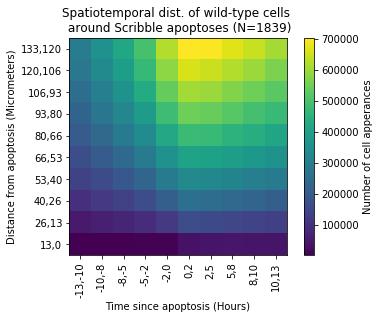

In [34]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/Spatiotemporal dist. of wild-type mitoses 
 around Scribble apoptoses (N=1839).pdf


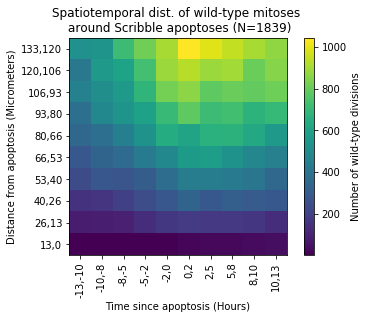

In [35]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type mitoses \n around Scribble apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/Spatiotemporal dist. of probability of wild-type division 
 around Scribble apoptoses (N=1839).pdf


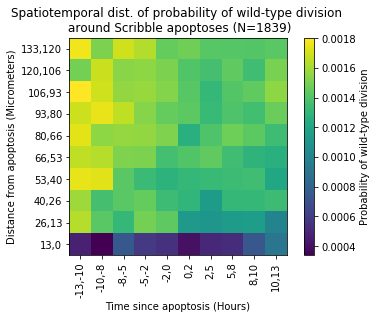

In [36]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around Scribble apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Probability of wild-type division', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

# 5) Miscellaneous section: segregating cumulative plots based on experiment type

50:50 expt

In [27]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types'
Path(save_path).mkdir(parents=True, exist_ok=True)

In [28]:
expt_list_5050 = ['GV0794/Pos4',
                 'GV0794/Pos7',
                 'GV0794/Pos16',
                 'GV0795/Pos4',
                 'GV0795/Pos7',
                 'GV0795/Pos17',
                 'GV0796/Pos4',
                 'GV0796/Pos7',
                 'GV0796/Pos21',
                 'GV0796/Pos22',
                 'GV0797/Pos4',
                 'GV0797/Pos7',
                 'GV0797/Pos20',
                 'GV0797/Pos21',
                 'GV0798/Pos4',
                 'GV0798/Pos7',
                 'GV0798/Pos20',
                 'GV0798/Pos21',
                 'GV0800/Pos4', 
                 'GV0800/Pos7',
                 'GV0800/Pos16',
                 'GV0801/Pos4',
                 'GV0802/Pos4',
                 'GV0804/Pos4',
                 'GV0805/Pos4',
                 'GV0806/Pos4',
                 'GV0807/Pos4',
                 'GV0812/Pos0',
                 'GV0812/Pos1',
                 'GV0812/Pos2',
                 'GV0812/Pos3',
                 'GV0812/Pos4',
                 'GV0812/Pos5',
                 'GV0813/Pos0',
                 'GV0813/Pos1',
                 'GV0813/Pos2',
                 'GV0813/Pos3',
                 'GV0813/Pos4',
                 'GV0813/Pos5',
                 'GV0814/Pos0',
                 'GV0814/Pos11',
                 'GV0814/Pos12',
                 'GV0814/Pos23',
                 'GV0815/Pos0',
                 'GV0815/Pos11',
                 'GV0815/Pos12',
                 'GV0815/Pos23',
                 'GV0816/Pos0',
                 'GV0816/Pos13',
                 'GV0816/Pos14',
                 'GV0816/Pos23',
                 'GV0817/Pos0',
                 'GV0817/Pos11',
                 'GV0817/Pos12',
                 'GV0817/Pos23',
                 'GV0818/Pos12',
                 'GV0818/Pos13',
                 'GV0819/Pos0',
                 'GV0819/Pos1',
                 'GV0819/Pos2',
                 'GV0819/Pos3',
                 'GV0819/Pos4',
                 'GV0819/Pos5',
                 'GV0820/Pos0',
                 'GV0820/Pos1',
                 'GV0820/Pos2',
                 'GV0820/Pos3',
                 'GV0820/Pos4',
                 'GV0820/Pos5']

In [37]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_5050:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

1111

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells 
 around Scribble apoptoses (N=1111, 50:50 wt:scr expts only).pdf


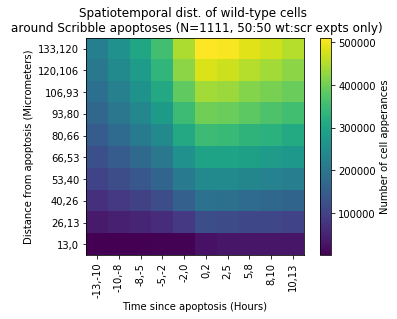

In [38]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division 
 around Scribble apoptoses (N=1111, 50:50 wt:scr expts only).pdf


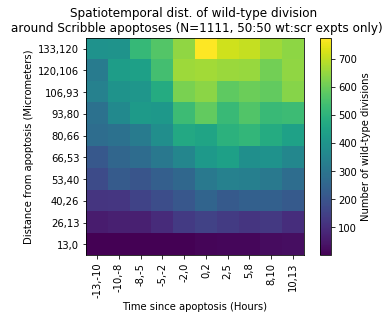

In [39]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of Scribble division 
 around wild-type apoptoses (N=1111, 50:50 wt:scr expts only).pdf


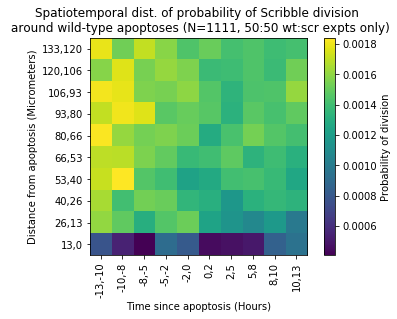

In [40]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of probability of Scribble division \n around wild-type apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

90:10 wt:scr

In [41]:
expt_list_9010 = ['GV0794/Pos3',
 'GV0794/Pos8',
 'GV0794/Pos15',
 'GV0795/Pos3',
 'GV0795/Pos8',
 'GV0795/Pos16',
 'GV0796/Pos3',
 'GV0796/Pos8',
 'GV0796/Pos19',
 'GV0796/Pos20',
 'GV0797/Pos3',
 'GV0797/Pos8',
 'GV0797/Pos18',
 'GV0797/Pos19',
 'GV0798/Pos3',
 'GV0798/Pos8',
 'GV0798/Pos18',
 'GV0798/Pos19',
 'GV0800/Pos3',
 'GV0800/Pos8',
 'GV0800/Pos15',
 'GV0801/Pos3',
 'GV0802/Pos3',
 'GV0804/Pos3',
 'GV0805/Pos3',
 'GV0806/Pos3',
 'GV0807/Pos3']

In [42]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_9010:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

131

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


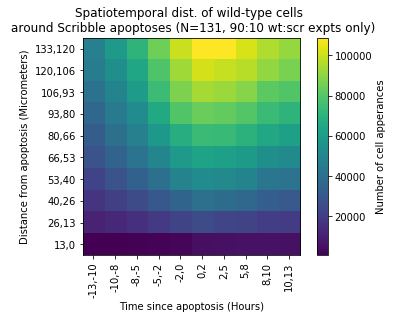

In [43]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


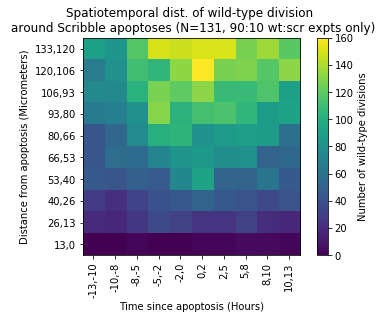

In [44]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of wild-type division 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


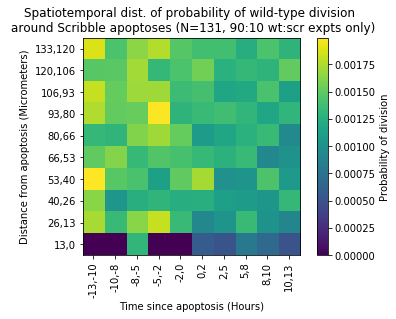

In [45]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

10:90 wt:scr

In [46]:
expt_list_1090 = ['GV0794/Pos5',
 'GV0794/Pos6',
 'GV0795/Pos5',
 'GV0795/Pos6',
 'GV0795/Pos18',
 'GV0796/Pos5',
 'GV0796/Pos6',
 'GV0796/Pos23',
 'GV0796/Pos24',
 'GV0797/Pos5',
 'GV0797/Pos6',
 'GV0797/Pos22',
 'GV0797/Pos23',
 'GV0798/Pos5',
 'GV0798/Pos6',
 'GV0798/Pos22',
 'GV0798/Pos23',
 'GV0800/Pos5',
 'GV0800/Pos6',
 'GV0800/Pos17',
 'GV0801/Pos5',
 'GV0802/Pos5',
 'GV0804/Pos5',
 'GV0805/Pos5',
 'GV0806/Pos5',
 'GV0807/Pos5']

In [47]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_1090:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

597

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


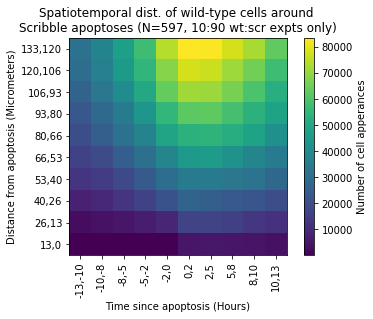

In [48]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


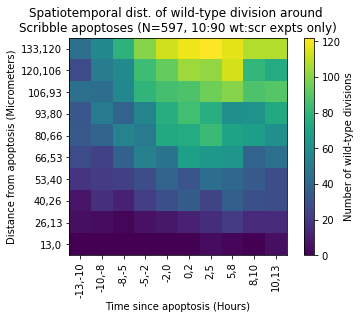

In [49]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of wild-type division around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


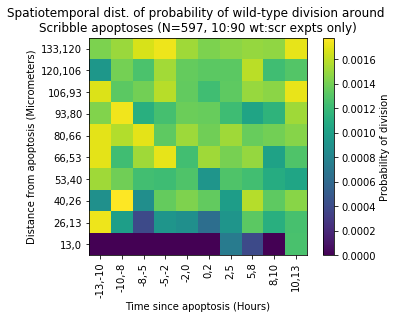

In [50]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Write a function to do a time evolving plot that iteratively adds single cell heat maps according to the apoptosis time?